In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 980

nband = 120

nv = 200

dv = 0.005

tsfc =257

ng =7

nref =2

p_refs = (/ 1 , 50 /) 

t_refs = (/ 250 , 250 /) 

ng_refs = (/ 4 , 3 /) 

data wgt
     &     /0.4 , 0.5 , 0.6 , 0.7,
     &     0.85 , 0.9 , 1/

option_wgt_flux =2

option_wgt_k =1

option_klin =0

data w_diffuse
     &     /1.6 , 1.6 , 1.6 , 1.6,
     &     1.6 , 1.6 , 1.6/

klin =0

atmosphere_profiles/saw75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

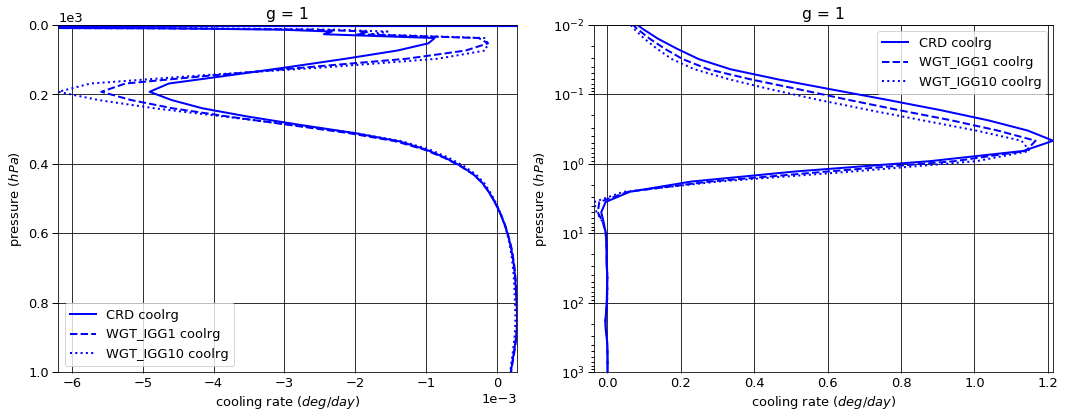

# Figure: cooling rate g-group 2

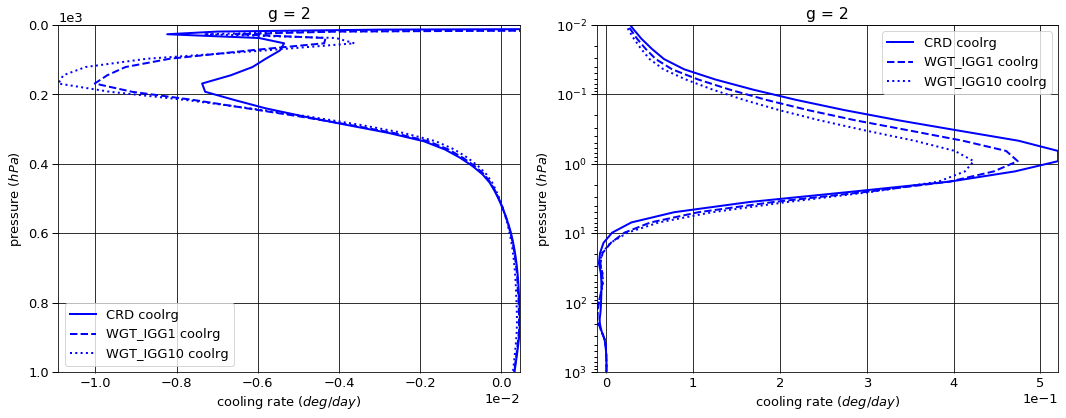

# Figure: cooling rate g-group 3

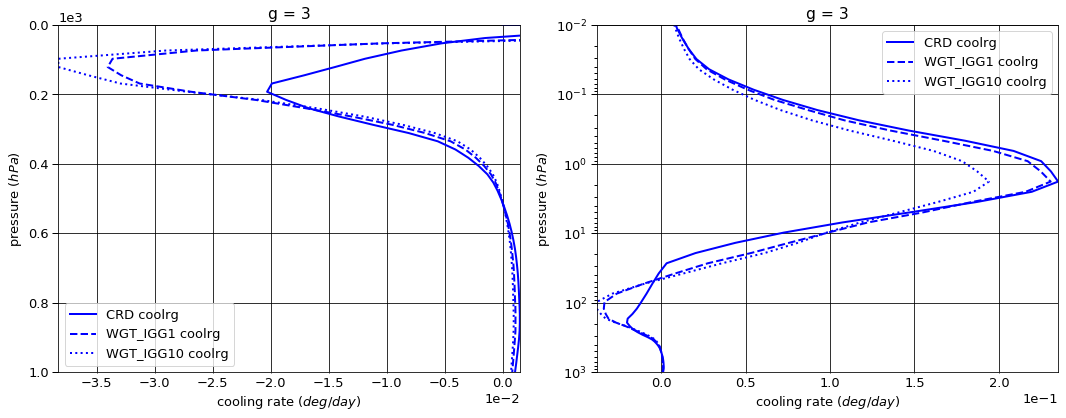

# Figure: cooling rate g-group 4

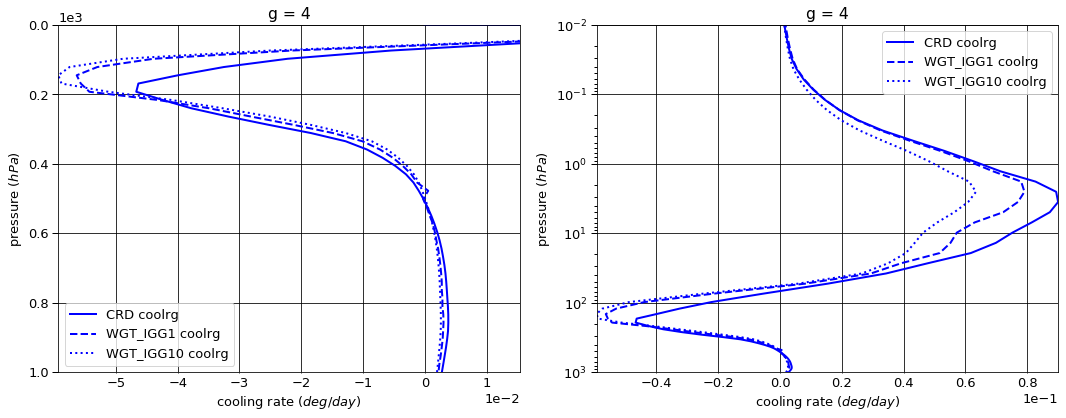

# Figure: cooling rate g-group 5

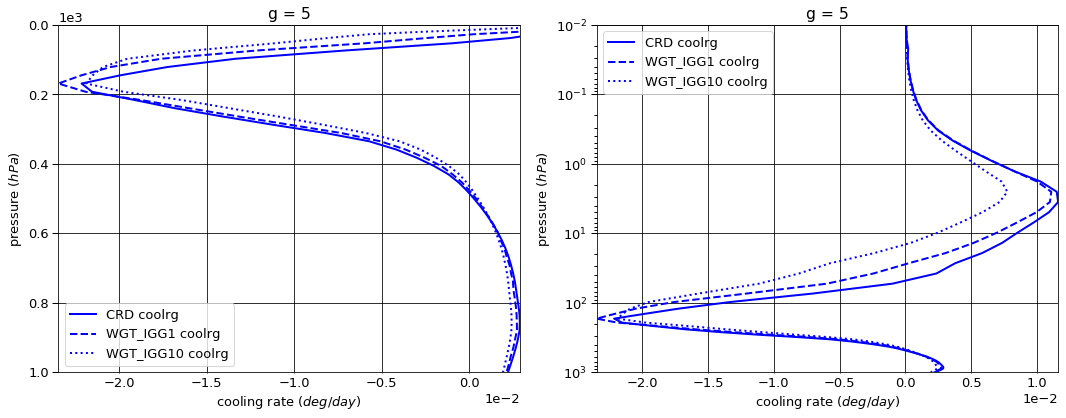

# Figure: cooling rate g-group 6

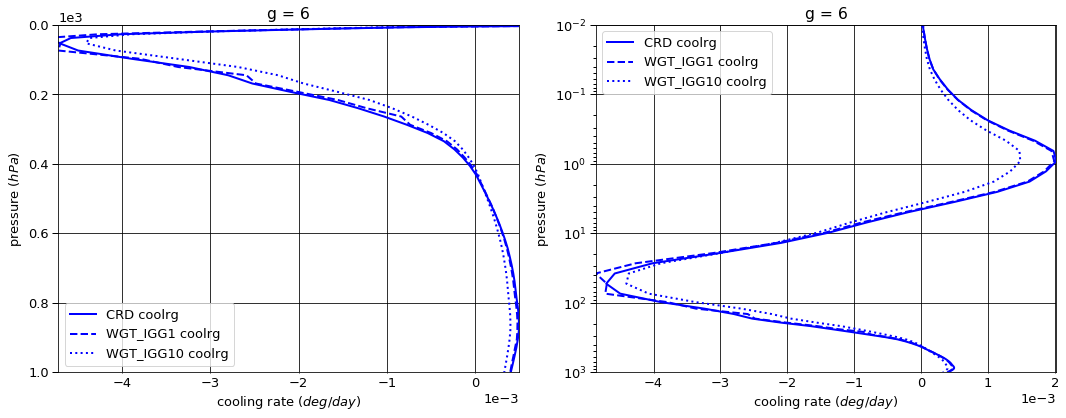

# Figure: cooling rate g-group 7

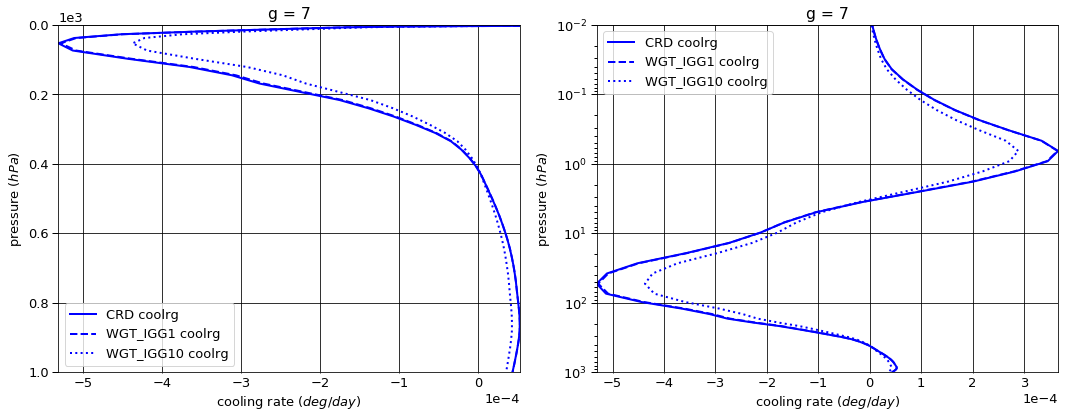

# Figure: cooling rate g-group total

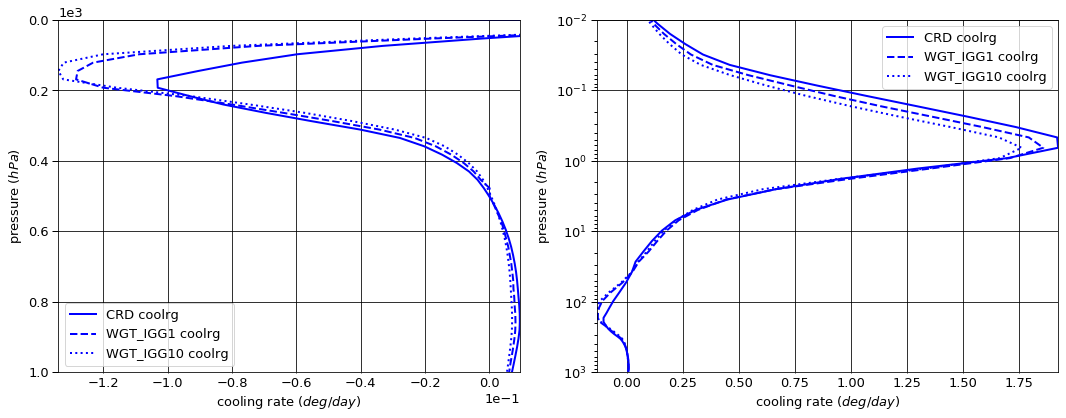

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.157997  0.000000 -0.157997
  1013.0   76    -0.197231  0.088941 -0.108290
2 0.0      1     -0.216548  0.000000 -0.216548
  1013.0   76    -0.407992  0.166080 -0.241912
3 0.0      1     -0.849919  0.000000 -0.849919
  1013.0   76    -1.566718  0.494720 -1.071998
4 0.0      1     -2.215743  0.000000 -2.215743
  1013.0   76    -3.968121  1.156549 -2.811573
5 0.0      1     -2.128964  0.000000 -2.128964
  1013.0   76    -3.249580  0.754177 -2.495402
6 0.0      1     -3.525358  0.000000 -3.525358
  1013.0   76    -3.727544  0.131468 -3.596076
7 0.0      1     -1.912858  0.000000 -1.912858
  1013.0   76    -1.934220  0.013410 -1.920810


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.159265  0.000000 -0.159265
  1013.0   76    -0.197231  0.089489 -0.107742
2 0.0      1     -0.198808  0.000000 -0.198808
  1013.0   76    -0.407992  0.170269 -0.237723
3 0.0      1     -0.576177  0.000000 -0.576177
  1013.0   76    -1.566718  0.590501 -0.976217
4 0.0      1     -1.748301  0.000000 -1.748301
  1013.0   76    -3.968122  1.331238 -2.636884
5 0.0      1     -2.026942  0.000000 -2.026942
  1013.0   76    -3.249580  0.796914 -2.452666
6 0.0      1     -3.527194  0.000000 -3.527194
  1013.0   76    -3.727544  0.130020 -3.597524
7 0.0      1     -1.912954  0.000000 -1.912954
  1013.0   76    -1.934220  0.013455 -1.920765


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.160010  0.000000 -0.160010
  1013.0   76    -0.197231  0.087124 -0.110107
2 0.0      1     -0.195373  0.000000 -0.195373
  1013.0   76    -0.407992  0.166442 -0.241551
3 0.0      1     -0.552574  0.000000 -0.552574
  1013.0   76    -1.566718  0.586645 -0.980073
4 0.0      1     -1.691108  0.000000 -1.691108
  1013.0   76    -3.968122  1.329471 -2.638651
5 0.0      1     -2.040566  0.000000 -2.040566
  1013.0   76    -3.249580  0.769292 -2.480287
6 0.0      1     -3.557631  0.000000 -3.557631
  1013.0   76    -3.727544  0.109860 -3.617684
7 0.0      1     -1.916917  0.000000 -1.916917
  1013.0   76    -1.934220  0.010939 -1.923280


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1     -1.268100e-03  0.000000 -0.001268
  1013.0   76     0.000000e+00  0.000548  0.000548
2 0.0      1      1.773956e-02  0.000000  0.017740
  1013.0   76     0.000000e+00  0.004189  0.004189
3 0.0      1      2.737418e-01  0.000000  0.273742
  1013.0   76     0.000000e+00  0.095781  0.095781
4 0.0      1      4.674416e-01  0.000000  0.467442
  1013.0   76    -4.440892e-16  0.174689  0.174689
5 0.0      1      1.020222e-01  0.000000  0.102022
  1013.0   76     0.000000e+00  0.042737  0.042737
6 0.0      1     -1.835200e-03  0.000000 -0.001835
  1013.0   76    -4.440892e-16 -0.001448 -0.001448
7 0.0      1     -9.580000e-05  0.000000 -0.000096
  1013.0   76     0.000000e+00  0.000045  0.000045


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1     -2.013070e-03  0.000000 -0.002013
  1013.0   76     0.000000e+00 -0.001817 -0.001817
2 0.0      1      2.117524e-02  0.000000  0.021175
  1013.0   76     0.000000e+00  0.000362  0.000362
3 0.0      1      2.973451e-01  0.000000  0.297345
  1013.0   76     0.000000e+00  0.091925  0.091925
4 0.0      1      5.246348e-01  0.000000  0.524635
  1013.0   76    -4.440892e-16  0.172922  0.172922
5 0.0      1      8.839800e-02  0.000000  0.088398
  1013.0   76     0.000000e+00  0.015115  0.015115
6 0.0      1     -3.227270e-02  0.000000 -0.032273
  1013.0   76    -4.440892e-16 -0.021608 -0.021608
7 0.0      1     -4.058900e-03  0.000000 -0.004059
  1013.0   76     0.000000e+00 -0.002470 -0.002470

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.817264e-02
  1001.112500 75     1.940105e-04
2 0.000312    1     -8.029486e-04
  1001.112500 75     3.200572e-04
3 0.000312    1      6.998634e-06
  1001.112500 75     1.051284e-03
4 0.000312    1     -2.961782e-05
  1001.112500 75     2.762091e-03
5 0.000312    1     -5.575445e-07
  1001.112500 75     2.209694e-03
6 0.000312    1     -7.647842e-06
  1001.112500 75     4.032554e-04
7 0.000312    1     -3.758798e-06
  1001.112500 75     4.328506e-05


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -1.870238e-02
  1001.112500 75     1.989018e-04
2 0.000312    1      1.270219e-04
  1001.112500 75     3.146748e-04
3 0.000312    1      4.348919e-04
  1001.112500 75     8.129729e-04
4 0.000312    1      8.224844e-05
  1001.112500 75     2.215631e-03
5 0.000312    1      4.472916e-07
  1001.112500 75     2.128400e-03
6 0.000312    1     -7.296549e-06
  1001.112500 75     3.970534e-04
7 0.000312    1     -3.757930e-06
  1001.112500 75     4.338114e-05


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -1.337209e-02
  1001.112500 75     1.860254e-04
2 0.000312    1      6.893481e-04
  1001.112500 75     2.823120e-04
3 0.000312    1      4.160632e-04
  1001.112500 75     7.080085e-04
4 0.000312    1      5.653162e-05
  1001.112500 75     1.982337e-03
5 0.000312    1     -7.866360e-07
  1001.112500 75     1.924364e-03
6 0.000312    1     -7.094440e-06
  1001.112500 75     3.294465e-04
7 0.000312    1     -3.134043e-06
  1001.112500 75     3.522953e-05


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      9.470255e-03
  1001.112500 75     4.891290e-06
2 0.000312    1      9.299705e-04
  1001.112500 75    -5.382340e-06
3 0.000312    1      4.278933e-04
  1001.112500 75    -2.383113e-04
4 0.000312    1      1.118663e-04
  1001.112500 75    -5.464608e-04
5 0.000312    1      1.004836e-06
  1001.112500 75    -8.129460e-05
6 0.000312    1      3.512925e-07
  1001.112500 75    -6.202040e-06
7 0.000312    1      8.675000e-10
  1001.112500 75     9.608200e-08


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.480055e-02
  1001.112500 75    -7.985060e-06
2 0.000312    1      1.492297e-03
  1001.112500 75    -3.774515e-05
3 0.000312    1      4.090646e-04
  1001.112500 75    -3.432757e-04
4 0.000312    1      8.614943e-05
  1001.112500 75    -7.797548e-04
5 0.000312    1     -2.290915e-07
  1001.112500 75    -2.853299e-04
6 0.000312    1      5.534017e-07
  1001.112500 75    -7.380897e-05
7 0.000312    1      6.247541e-07
  1001.112500 75    -8.055530e-06

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-11.007387,0.000000,-11.007387
1013.0,76,-15.051406,2.805346,-12.246061



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-10.149641,0.000000,-10.149641
1013.0,76,-15.051406,3.121886,-11.929520



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-10.114179,0.000000,-10.114179
1013.0,76,-15.051406,3.059774,-11.991633



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.857746,0.000000,0.857746
1013.0,76,0.000000,0.316541,0.316541



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.893208,0.000000,0.893208
1013.0,76,0.000000,0.254428,0.254428


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.029010
1001.112500,75,0.006984



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.018069
1001.112500,75,0.006111



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.012221
1001.112500,75,0.005448



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.010941
1001.112500,75,-0.000873



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.016789
1001.112500,75,-0.001536


In [20]:
table_dgdgs.display_dgdgs(crd)

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.013083,0.013101
2,0.026792,0.027120
3,0.102833,0.104146
4,0.259042,0.263859
5,0.212917,0.216035
6,0.245292,0.247839
7,0.140042,0.127900


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.310613e-18
2,2.305341e-19
3,2.300081e-20
4,2.294833e-21
5,1.127464e-20
6,1.127564e-21
7,1.127665e-22


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.310613e-18,NaN,0.013083,0.013101,0.013083,0.013101,1.0
2,2.305341e-19,0.099772,0.026792,0.027120,0.039875,0.040221,1.0
3,2.300081e-20,0.099772,0.102833,0.104146,0.142708,0.144366,1.0
4,2.294833e-21,0.099772,0.259042,0.263859,0.401750,0.408226,1.0
5,1.127464e-20,4.913053,0.212917,0.216035,0.614667,0.624261,50.0
6,1.127564e-21,0.100009,0.245292,0.247839,0.859958,0.872100,50.0
7,1.127665e-22,0.100009,0.140042,0.127900,1.000000,1.000000,50.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     8.117909e-18  4.543180e-18   1.786834  1.280610e-05
      2 0.000312     5.216139e-19  2.838866e-19   1.837402  8.634855e-07
      3 0.000312     3.202191e-20  1.789001e-20   1.789933  5.653473e-08
      4 0.000312     2.523620e-21  1.172986e-21   2.151450  4.541854e-09
      5 0.000312     9.052652e-23  8.887391e-23   1.018595  1.935549e-10
      6 0.000312     1.094312e-22  8.606952e-23   1.271428  2.296087e-10
      7 0.000312     7.873532e-23  2.400901e-23   3.279407  1.688064e-10
2     1 0.000750     8.102497e-18  4.559878e-18   1.776911  6.005986e-06
      2 0.000750     5.279184e-19  2.877547e-19   1.834613  4.098196e-07
      3 0.000750     3.263469e-20  1.819848e-20   1.793265  2.699080e-08
      4 0.000750     2.564174e-21  1.195080e-21   2.145608  2.163916e-09
      5 0.000750     9.320363e-23  9.151171e-23   1.018489  9.340178e-11
      6 0.000750     1.120663e-22  8.821823e-23   1.270331  1.102148e-10
      7 0.000750     7.963984e-23  2.435763e-23   3.269606  8.002706e-11
3     1 0.001052     8.070915e-18  4.592666e-18   1.757349  1.083925e-05
      2 0.001052     5.407276e-19  2.955775e-19   1.829394  7.574342e-07
      3 0.001052     3.390244e-20  1.881106e-20   1.802261  5.047578e-08
      4 0.001052     2.648025e-21  1.237619e-21   2.139612  4.030151e-09
      5 0.001052     9.845144e-23  9.667325e-23   1.018394  1.778501e-10
      6 0.001052     1.176511e-22  9.271833e-23   1.268908  2.085948e-10
      7 0.001052     8.156963e-23  2.506877e-23   3.253834  1.477538e-10
4     1 0.001476     8.037930e-18  4.624631e-18   1.738069  1.868456e-05
      2 0.001476     5.538683e-19  3.036167e-19   1.824235  1.337384e-06
      3 0.001476     3.524587e-20  1.944518e-20   1.812576  9.022812e-08
      4 0.001476     2.739225e-21  1.282222e-21   2.136310  7.181056e-09
      5 0.001476     1.042855e-22  1.024076e-22   1.018338  3.244210e-10
      6 0.001476     1.237823e-22  9.759100e-23   1.268378  3.779464e-10
      7 0.001476     8.368220e-23  2.580959e-23   3.242290  2.610314e-10
5     1 0.002070     8.003921e-18  4.655306e-18   1.719311  3.120066e-05
      2 0.002070     5.671742e-19  3.117742e-19   1.819183  2.287315e-06
      3 0.002070     3.665175e-20  2.009393e-20   1.824021  1.562888e-07
      4 0.002070     2.837325e-21  1.328553e-21   2.135651  1.241152e-08
      5 0.002070     1.107256e-22  1.087332e-22   1.018324  5.747340e-10
      6 0.002070     1.304396e-22  1.028012e-22   1.268854  6.645094e-10
      7 0.002070     8.596647e-23  2.657153e-23   3.235285  4.474265e-10
6     1 0.002904     7.968872e-18  4.684649e-18   1.701061  5.094430e-05
      2 0.002904     5.806400e-19  3.200510e-19   1.814211  3.824816e-06
      3 0.002904     3.812270e-20  2.075851e-20   1.836486  2.647886e-07
      4 0.002904     2.942977e-21  1.376889e-21   2.137410  2.100464e-08
      5 0.002904     1.178726e-22  1.157482e-22   1.018354  9.983935e-10
      6 0.002904     1.376758e-22  1.083699e-22   1.270425  1.144401e-09
      7 0.002904     8.843570e-23  2.735510e-23   3.232878  7.510906e-10
7     1 0.004074     7.931917e-18  4.712260e-18   1.683251  8.175059e-05
      2 0.004074     5.941993e-19  3.284284e-19   1.809220  6.285318e-06
      3 0.004074     3.965766e-20  2.143967e-20   1.849733  4.410417e-07
      4 0.004074     3.056629e-21  1.427582e-21   2.141124  3.498737e-08
      5 0.004074     1.258422e-22  1.235655e-22   1.018425  1.709924e-09
      6 0.004074     1.455356e-22  1.143110e-22   1.273155  1.940354e-09
      7 0.004074     9.109474e-23  2.815992e-23   3.234908  1.241149e-09
8     1 0.005714     7.892088e-18  4.737690e-18   1.665809  1.293936e-04
      2 0.005714     6.077764e-19  3.368877e-19   1.804092  1.018706e-05
      3 0.005714     4.125523e-20  2.213921e-20   1.863447  7.248611e-07
      4 0.005714     3.178818e-21  1.481172e-21   2.146150  5.757518e-08
      5 0.0

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
